# Churn Modeling in Telecom data

Machine Learning Problem: Given customer activities, predict whether customer will churn or not

Type: Binary classification problem (with imbalance target distribution)

Performance metrics: ROC AUC

Dataset: [Kaggle Churn Dataset](https://www.kaggle.com/mnassrib/telecom-churn-datasets/code)

In [1]:
# Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling
from sklearn.metrics import f1_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read dataset
df_train = pd.read_csv("data/churn-bigml-80.csv")
df_test = pd.read_csv("data/churn-bigml-20.csv")

df_train.shape, df_test.shape

((2666, 20), (667, 20))

In [3]:
# Check dataset columns
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2666 entries, 0 to 2665
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   State                   2666 non-null   object 
 1   Account length          2666 non-null   int64  
 2   Area code               2666 non-null   int64  
 3   International plan      2666 non-null   object 
 4   Voice mail plan         2666 non-null   object 
 5   Number vmail messages   2666 non-null   int64  
 6   Total day minutes       2666 non-null   float64
 7   Total day calls         2666 non-null   int64  
 8   Total day charge        2666 non-null   float64
 9   Total eve minutes       2666 non-null   float64
 10  Total eve calls         2666 non-null   int64  
 11  Total eve charge        2666 non-null   float64
 12  Total night minutes     2666 non-null   float64
 13  Total night calls       2666 non-null   int64  
 14  Total night charge      2666 non-null   

In [4]:
# Check whether there is missing value in data
df_train.isnull().sum()
# There is no missing value

State                     0
Account length            0
Area code                 0
International plan        0
Voice mail plan           0
Number vmail messages     0
Total day minutes         0
Total day calls           0
Total day charge          0
Total eve minutes         0
Total eve calls           0
Total eve charge          0
Total night minutes       0
Total night calls         0
Total night charge        0
Total intl minutes        0
Total intl calls          0
Total intl charge         0
Customer service calls    0
Churn                     0
dtype: int64

,label,Churn
0,False,0.854464
1,True,0.145536


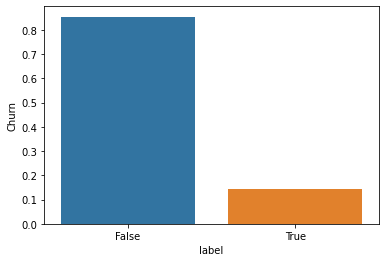

In [5]:
# Distribution of target variable which is Churn
dfx = df_train.Churn.value_counts(normalize=True).reset_index()
dfx = dfx.rename(columns={'index':'label'})
sns.barplot(data=dfx, x='label', y='Churn')
dfx
# The class distribution is imbalance
# Because we have positive class "Churn" with only 14.5% of training data
# In this case, we couldn't use accuracy as performance metrics in the model development
# We could use ROC AUC / PR AUC
# and could check precision, recall, f1-score as secondary performance metrics

### Exploratory Data Analysis (EDA)

In [6]:
# See 5 samples in the dataframe
df_train.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [7]:
# Check binary features
df_train['International plan'].value_counts()

No     2396
Yes     270
Name: International plan, dtype: int64

In [8]:
# Additional binary features
df_train['Voice mail plan'].value_counts()

No     1933
Yes     733
Name: Voice mail plan, dtype: int64

In [9]:
# Encode binary to numerical using map to dictionary
map_binary = {'Yes': 1, 'No': 0}
df_train['International plan'] = df_train['International plan'].map(map_binary)
df_train['Voice mail plan'] = df_train['Voice mail plan'].map(map_binary)

df_test['International plan'] = df_test['International plan'].map(map_binary)
df_test['Voice mail plan'] = df_test['Voice mail plan'].map(map_binary)

In [10]:
# See distribution of numerical features
numerical_features = df_train.select_dtypes(include=['float', 'int']).columns.to_list()
print("number of numerical features", len(numerical_features))
print(numerical_features)

number of numerical features 18
['Account length', 'Area code', 'International plan', 'Voice mail plan', 'Number vmail messages', 'Total day minutes', 'Total day calls', 'Total day charge', 'Total eve minutes', 'Total eve calls', 'Total eve charge', 'Total night minutes', 'Total night calls', 'Total night charge', 'Total intl minutes', 'Total intl calls', 'Total intl charge', 'Customer service calls']


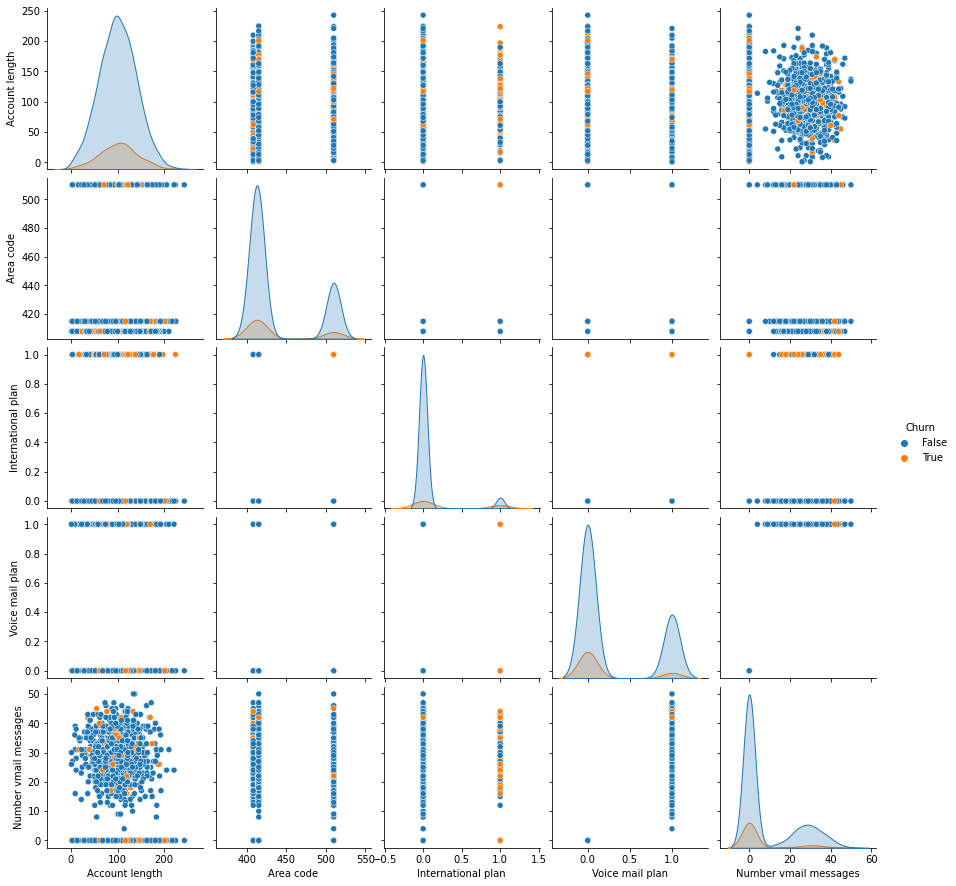

In [11]:
# Distribution of Numerical Features
sns.pairplot(df_train[numerical_features[:5] + ['Churn']], hue='Churn')

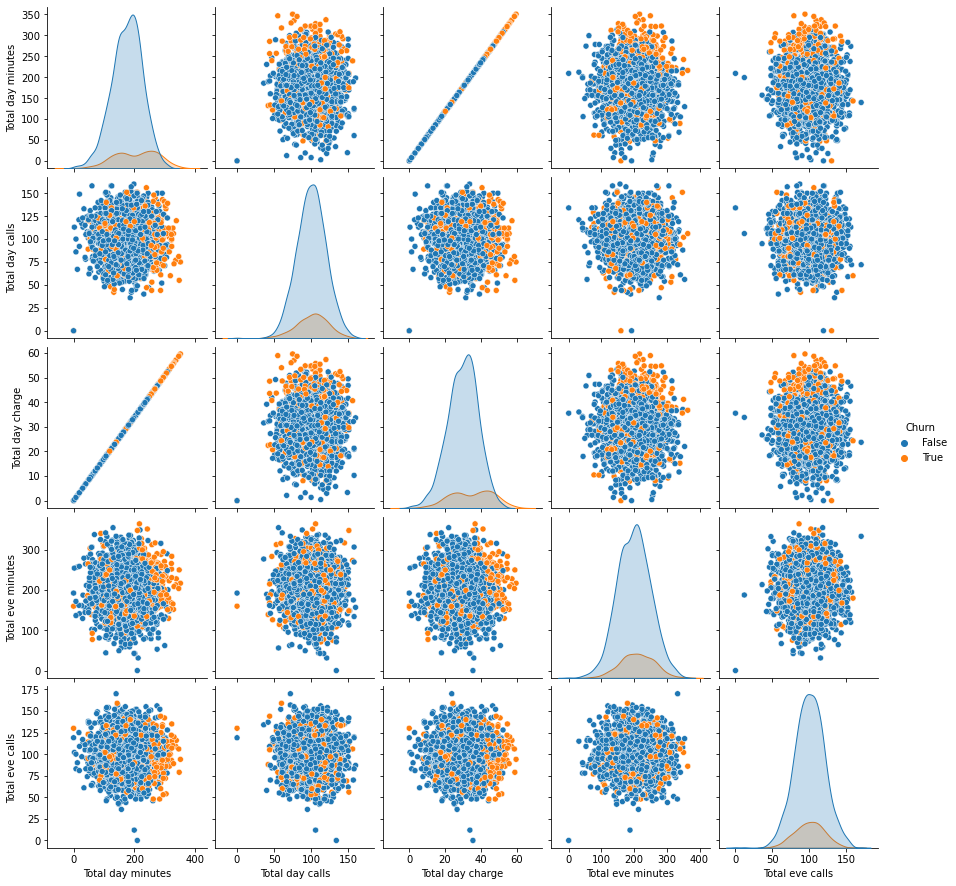

In [12]:
# Distribution of Numerical Features - Cont
sns.pairplot(df_train[numerical_features[5:10] + ['Churn']], hue='Churn')

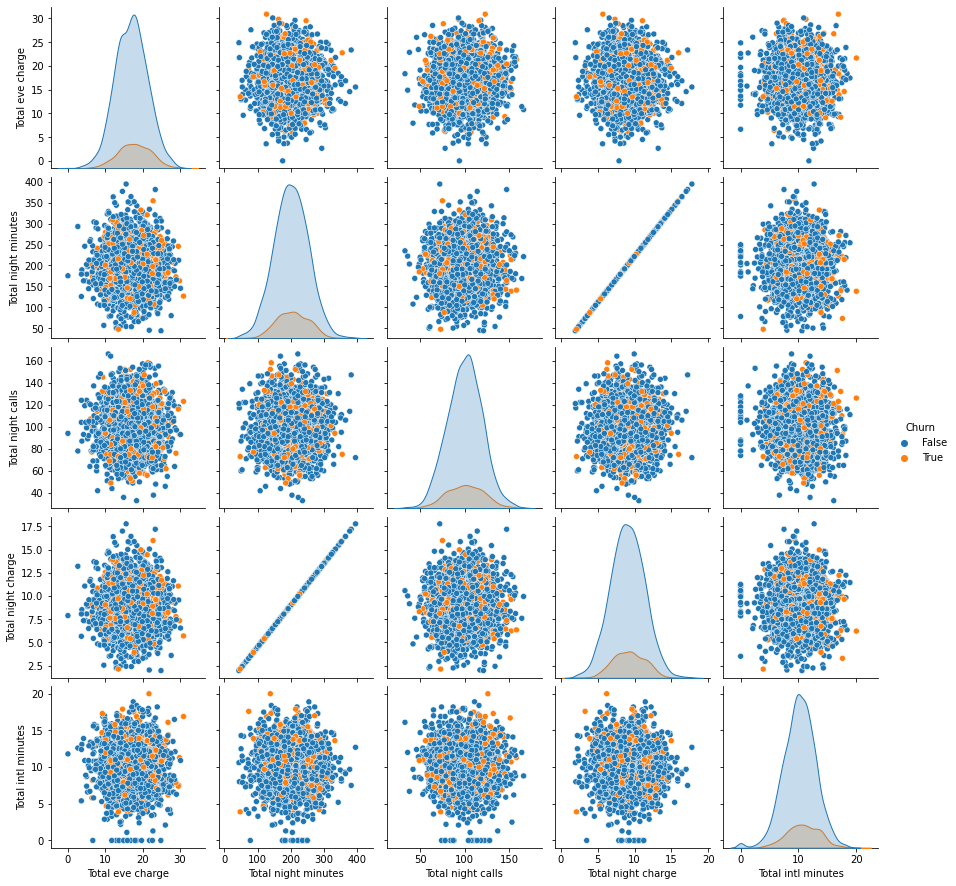

In [13]:
# Distribution of Numerical Features - Cont
sns.pairplot(df_train[numerical_features[10:15] + ['Churn']], hue='Churn')

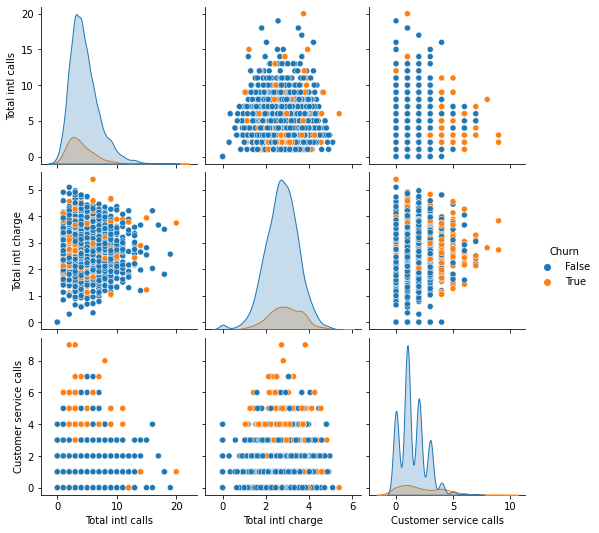

In [14]:
# Distribution of Numerical Features - Cont
sns.pairplot(df_train[numerical_features[15:] + ['Churn']], hue='Churn')

### Functions

In [15]:
def plot_roc_auc(y_val, y_proba):
    """Given y_val and y_proba, plot ROC AUC curve
    """
    fpr, tpr, threshold = roc_curve(y_val, y_proba)
    roc_auc = auc(fpr, tpr)

    # plot roc auc curve
    plt.figure(figsize=(4,4))
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc, color='darkorange')
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--', color='navy')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

def evaluate_model(model, X_train, y_train, X_test, y_test):
    """ Given model, X_train, X_test, y_train, y_test
    Show ROC AUC in test set, Classification Report, and plot prediction probability distribution
    """
    # train model
    model.fit(X_train, y_train)
    # predict test set
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    print("ROC AUC in test set")
    plot_roc_auc(y_test, y_proba)
    print("Classification Report")
    print(classification_report(y_pred, y_test))
    print("Prediction Proba Distribution")
    sns.distplot(y_proba)

### Modeling

ROC AUC in test set


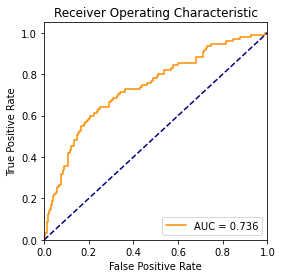

Classification Report
              precision    recall  f1-score   support

       False       0.98      0.87      0.92       650
        True       0.08      0.47      0.14        17

    accuracy                           0.86       667
   macro avg       0.53      0.67      0.53       667
weighted avg       0.96      0.86      0.90       667

Prediction Proba Distribution


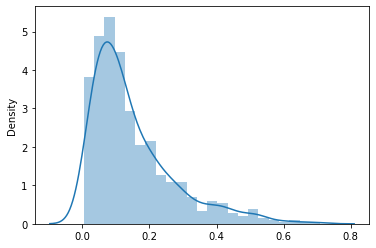

In [16]:
# For simplicity we want to model the problem only using numerical features
# Without performing anything to address the imbalance problem
model = LogisticRegression()

y_train = df_train['Churn']
X_train = df_train[numerical_features]
y_test = df_test['Churn']
X_test = df_test[numerical_features]

evaluate_model(model, X_train, y_train, X_test, y_test)

### Additional Modeling

In [17]:
# At this point we want to improve the model by adding class_weight to the model
# So it will penalize more if the model falsely predict the positive class

# We will define the class weight inverse proportionally to the number of sample for the class
dfx = df_train['Churn'].value_counts().reset_index()
dfx['total'] = dfx.Churn.sum()
dfx['weight'] = dfx.total / (dfx.Churn)

# Get weights
weights = dfx.weight.to_dict()

print(dfx)
print(weights)

   index  Churn  total    weight
0  False   2278   2666  1.170325
1   True    388   2666  6.871134
{0: 1.170324846356453, 1: 6.871134020618556}


ROC AUC in test set


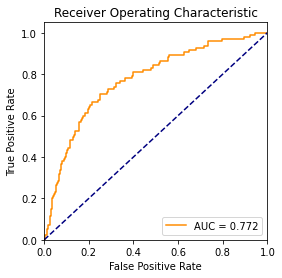

Classification Report
              precision    recall  f1-score   support

       False       0.69      0.94      0.79       418
        True       0.74      0.28      0.41       249

    accuracy                           0.69       667
   macro avg       0.71      0.61      0.60       667
weighted avg       0.71      0.69      0.65       667

Prediction Proba Distribution


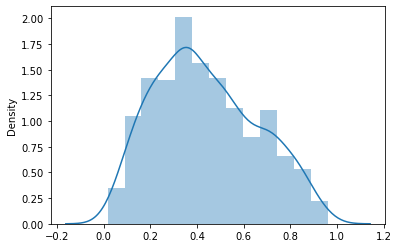

In [18]:
# For simplicity we want to model the problem only using numerical features
# Without performing anything to address the imbalance problem
model = LogisticRegression(class_weight=weights)

y_train = df_train['Churn']
X_train = df_train[numerical_features]
y_test = df_test['Churn']
X_test = df_test[numerical_features]

evaluate_model(model, X_train, y_train, X_test, y_test)

In [19]:
# Quiz
# Experiment with different algorithms or features engineering and see the result in performance metrics
# Try by yourself!